## Lawrence Livermore National Laboratory Speciation Updated Random Forest Model
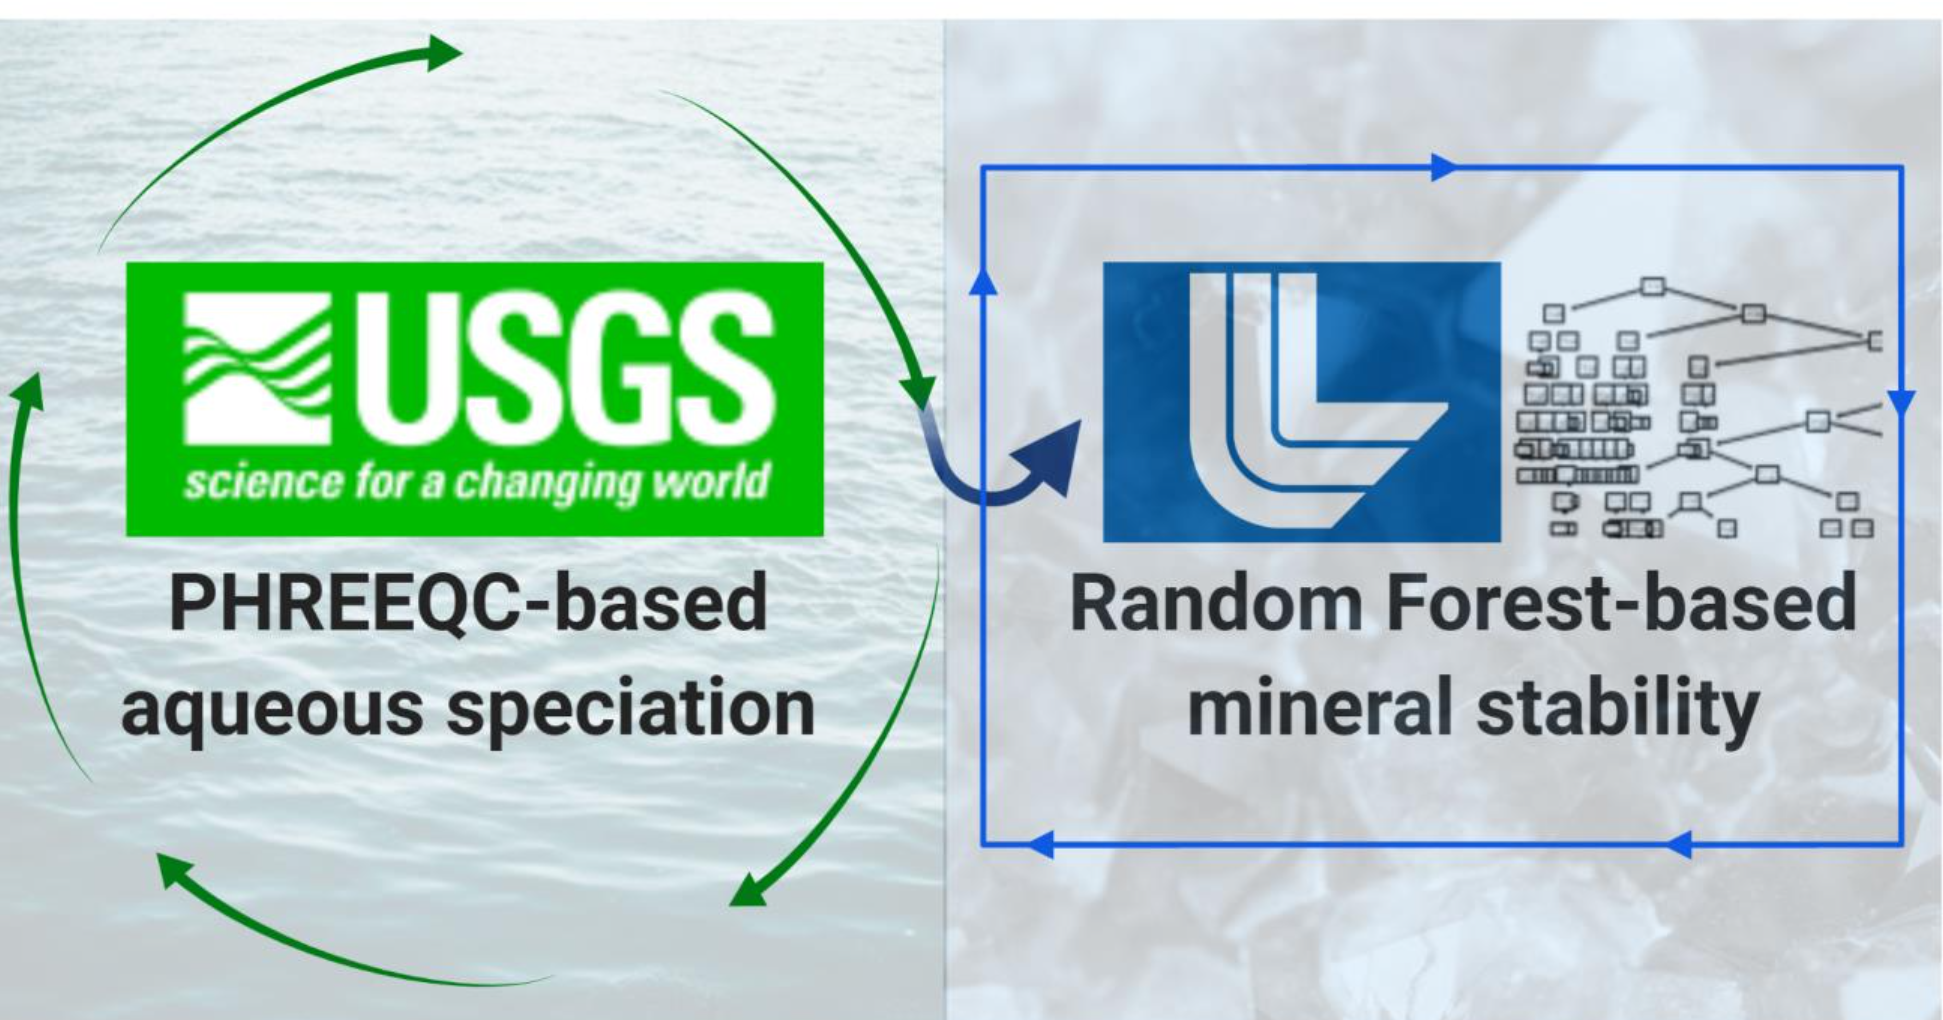
### Code written by Elliot Chang (LLNL) , Linda Beverly (LLNL), Sol-Chan Han (LLNL), Haotian Zeng (LBL), Jadallah Zouabe (UCB)
### Code distribution license obtained from LLNL Intellectual Property Office


### Required Imports

In [1]:
#importing package dependencies
import csv
import math
import re
import subprocess
from typing import List, Tuple, Union
from textwrap import dedent

import joblib
from math import sqrt
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from pandas import Float64Index
from scipy import stats
import seaborn as sns
import shap
from sklearn import metrics 
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Defining database file name

In [2]:
database = "sc.subset.csv"

### Preparing Paths

In [3]:
# Windows 
phreeqc_dir = r"C:\Users\chang58\Desktop\LSURF_Package1"
phreeqc_path = phreeqc_dir + r"\phreeqc.exe"
phreeqc_input = phreeqc_dir + r"\python_trial.txt" 
phreeqc_output = phreeqc_dir + r"\python_trial.out"
phreeqc_results = phreeqc_dir + r"\python_trial_output.txt"
phreeqc_db =  phreeqc_dir+ r"\LLNL_NEA.txt"

### Importing Dataset

In [4]:
#----------Description-----------
#Purpose: This function imports user data
#Returns: Pandas DataFrame of user's data
def import_data(data):
    """
    Function import_data() imports user's csv and returns it as a pandas data frame.
    
    Args:
        data (str): Name of CSV file
    Returns:
        pandas dataframe
    Notes:
        user's csv file name should originate from Mavrik's database.
   
    """
    df=pd.read_csv(data) 
    return df

In [5]:
# Ensure no cutting-off of dataset digits by setting significant values to 15. 
pd.set_option("display.precision", 15)

df=import_data(database)
df_temp=import_data(database)

In [6]:
# Modify gas concentrations to atm units
Gas1_atm=df.Gas1_val/1.013
Gas2_atm=df.Gas2_val/1.013
Gas3_atm=df.Gas3_val/1.013
df = df.replace(np.nan, 0)

# Ensure no negative, unrealistic values for aqueous and sorbed concentrations.
df.loc[(df.Aq_val < 0), 'Aq_val'] = df.Aq_SD
df.loc[df.Sorbed_val < 0,'Sorbed_val'] = (df.Aq_val)/10000

In [7]:
def find_electrolytes(cols: List[str]) -> List[str]:
    return [x for x in cols if re.match(r'^Electrolyte\d+$', x)]
    
def find_gases(cols: List[str]) -> List[str]:
    return [x for x in cols if re.match(r'^Gas\d+$', x)]

def find_columns(cols: List[str]) -> List[str]:
    found_cols = ['Sorbent']
    found_cols.extend(find_electrolytes(cols))
    found_cols.extend(find_gases(cols))
    return found_cols

def create_column_value_pairs(cols: List[str]) -> List[Tuple[str, str]]:
    value_cols = [f'{x}_val' for x in cols]
    return zip(cols, value_cols)
    
def pivot_pairs(df: np.ndarray, column_value_pairs: List[Tuple[str, str]]) -> np.ndarray:
    pivotdf=pd.DataFrame([]) 

    for col, val in column_value_pairs:
        add = df[[col, val]].pivot(columns=col, values=val)

        # Eliminate `NaN`s columns by using the fact that NaN != Nan
        if add.columns[0] == add.columns[0]:        
            pivotdf = pd.concat([pivotdf, add], axis=1)

    return pivotdf
    

def pull_data(userdata: Union[str, np.ndarray]) -> np.ndarray:
    """Function pull_data simplifies input dataset for the purpose of
    running data analytics
    
    Args:
        userdata (str or pandas dataframe): If str(), csv imported as pandas
            dataframe. If userdata is pandas dataframe, dataset is stored.
    Returns:
        pandas dataframe : Reference,Mineral_source,pH, Sorbent initial 
            concentration,Concentration Sorbed material 
            Electrolytes Sorbent initial concentration, Amot Sorbed, pH, 
            site density, and target variable(s) are the columns.   
    """
    # Checking to see if userdata is filepath or if it is a pre-existing datafreame
    if isinstance(userdata,str):
        df=pd.read_csv(userdata) #user data could be string linking LLNL csv to filepoath
    else:
        df=userdata  #user data could be string already defined as a Pandas DataFrame
 
    found_cols = find_columns(df.columns.tolist()) 
    column_pairs = create_column_value_pairs(found_cols)
    pivotdf = pivot_pairs(df, column_pairs)

    wanted_cols = [ 'Reference', 'Mineral_source', 'pH', 'Mineral',
                        'Mineral_val', 'MineralSA', 'Mineralsites' ]
    combineddf = pd.concat([pivotdf, df[wanted_cols]], axis=1)
    
    #'U(+6)', 'Na(+1)', 'Mineral', 'K(+1)','Ca(+2)', 'Cl(+7)', 'Cl(-1)', 'N(+5)',
    #'F(-1)', 'P(+5)', 'Si(+4)','N2(g)', 'O2(g)', 'CO2(g)', 'C(+4)',
    finaldf = combineddf[['Reference', 'Mineral_source', 'pH', 'Mineral'] + 
                          pivotdf.columns.tolist() + 
                          ['Mineral_val','MineralSA', 'Mineralsites']]

    
    finaldf.index.name='Experiment'
    finaldf.index+=1
    return finaldf
    

### PHREEQC-based Aqueous Speciation Iterations

In [8]:
# Function to iterate through phreeqc and calculate aqueous speciation results
def importingphreeqc(df):
    df = df.replace(np.nan, 0)
    
    phreeqc_in = dedent(f'''
       TITLE Python_Phreeqc_Call


       SELECTED_OUTPUT
       -file {phreeqc_results}
       -activities UO2+2 UO2CO3
       ionic_strength true

       END
    ''')

    for n in range(0, df.shape[0]):
        fixedpH = df.pH[n] * -1

        simulation = dedent(f'''
            SOLUTION {n}
            units mol/L
            pH {df.pH[n]:0.3f}
            {re.sub("[^a-zA-Z]+", "", df.Electrolyte1[n])} {df.Electrolyte1_val[n]:0.3f}
            {re.sub("[^a-zA-Z]+", "", df.Electrolyte2[n])} {df.Electrolyte2_val[n]:0.3f}
            {re.sub("[^a-zA-Z]+", "", df.Electrolyte3[n])} {df.Electrolyte3_val[n]:0.3f}
            {df.Sorbent[n]} {df.Sorbent_val[n]:0.8f}

            GAS_PHASE {n}
            -fixed_pressure
            -pressure 1.0
            -volume 1.0
            -temperature 25.0
             {df.Gas1[n]} {Gas1_atm[n]:0.8f}
             {df.Gas2[n]} {Gas2_atm[n]:0.8f}
             {df.Gas3[n]} {Gas3_atm[n]:0.8f}
             PHASES
             Fix_H+
             H+ = H+
             log_k 0.0
        ''')

        # For charge balance, add HCl or NaOH (buffer pH of system)
        fix = 'HCl 10.0' if df.pH[n] > 10 else 'NaOH 10.0'
        simulation += dedent(f'''
        
            EQUILIBRIUM_PHASES {n}
            Fix_H+ {fixedpH:0.3f} {fix}
             END

        ''')
            
        phreeqc_in += simulation

    with open(phreeqc_input, "w+") as t:
        t.write(phreeqc_in)
    
    #Execute phreeqc batch file
    # This must be an array
    cmd = [phreeqc_path, phreeqc_input, phreeqc_output, phreeqc_db]
    phreeqc_run = subprocess.run(cmd)
    print(phreeqc_run)
    print(phreeqc_run.stdout)
    print(phreeqc_run.stderr)

    #Import in the data from the batch file run
    read_file=pd.read_csv(phreeqc_results, delimiter='\t')
    clean_columns = [x.strip() for x in read_file.columns]
    phreeqc_calc_cleaned = pd.DataFrame([], columns=clean_columns)
    phreeqc_calc_cleaned[clean_columns] = read_file[read_file.columns].applymap(
        lambda x: x.strip() if isinstance(x, str) else x
    )

    Mu=phreeqc_calc_cleaned[phreeqc_calc_cleaned['state'] == 'react']['mu']
    Uranyl_Activity=phreeqc_calc_cleaned[phreeqc_calc_cleaned['state'] == 'react']['la_UO2+2']
    C_activity=phreeqc_calc_cleaned[phreeqc_calc_cleaned['state'] == 'react']['la_UO2CO3']
    
    return df, Mu, C_activity, Uranyl_Activity

In [9]:
# Set up normal distribution probability for Monte Carlo simulations
#df is the originating dataframe, df_temp is the new +/- error included dataframe

def MC_Phreeqc(df, df_temp):

    df_temp["Electrolyte1_val"] = np.random.normal(df["Electrolyte1_val"],df["Electrolyte1_SD"])
    df_temp["Electrolyte2_val"] =np.random.normal(df["Electrolyte2_val"],df["Electrolyte2_SD"])
    df_temp["pH"] = np.random.normal(df["pH"],df["pH_SD"])
    df_temp["Sorbent_val"] = np.random.normal(df["Sorbent_val"],df["Sorbent_SD"])
    df_temp["Mineral_val"] = np.random.normal(df["Mineral_val"],df["Mineral_SD"])
    df_temp["MineralSA"] = np.random.normal(df["MineralSA"],df["MineralSA_SD"])
    df_temp["Aq_val"] = np.random.normal(df["Aq_val"],df["Aq_SD"])
    Gas1_atm = np.random.normal(df["Gas1_val"]/1.013,df["Gas1_SD"]/1.013)
    Gas2_atm =np.random.normal(df["Gas2_val"]/1.013,df["Gas2_SD"]/1.013)
    Gas3_atm = np.random.normal(df["Gas3_val"]/1.013,df["Gas3_SD"]/1.013)
    
    df_temp = df_temp.replace("NA",0)
    return df_temp, Gas1_atm, Gas2_atm, Gas3_atm

In [10]:
def solo_transformation(df):
    df_pull_clean = pull_data(database)
    df_pull_clean["Set"] = np.array(df["Set"])
    _, mu_values, C_activity, U_activity = importingphreeqc(df)

    MLreadydata, Aq_U_array = transformation(df, df_pull_clean, mu_values, C_activity, U_activity)
    MLreadydata = MLreadydata.drop(columns=["Set"])

    return MLreadydata, Aq_U_array


# Transforms the inputs of a Monte Carlo generated dataframe in preparation for RF modeling.
def randomized_transformation(df, df_temp):
    randomizedvalues, mu_values, C_activity, U_activity = importingphreeqc(
        MC_Phreeqc(df, df_temp)[0]
    )
    randomizedvalues = randomizedvalues.replace(0, "NA")
    randomizedvalues.to_csv("MCPhreeqc.csv", index=False)
    df_pull_clean = pull_data("MCPhreeqc.csv")

    MLreadydata, Aq_U_array = transformation(df, df_pull_clean, mu_values, C_activity, U_activity)
    return MLreadydata, Aq_U_array


def transformation(df, df_pull_clean, mu_values, C_activity, U_activity):
    df_pull_clean = df_pull_clean.drop(columns=["Reference"])

    inverse_pH = df_pull_clean["pH"] * -1
    H_concentration = 10**inverse_pH

    le = LabelEncoder()
    le2 = LabelEncoder()
    X_2 = le.fit_transform(df_pull_clean.Mineral)
    df_pull_clean["Mineral"] = X_2
    Y_2 = le2.fit_transform(df_pull_clean.Mineral_source)
    df_pull_clean["Mineral_source"] = Y_2

    uranium_initial = np.log10(np.array(df_pull_clean["U(+6)"]))
    site_density = np.log10(
        np.array(df_pull_clean["Mineral_val"])
        * np.array(df_pull_clean["Mineralsites"])
        * np.array(df_pull_clean["MineralSA"])
        * math.pow(10, 18)
        * 6.02
        * math.pow(10, -23)
    )
    Aq_U_array = np.log10(np.array(df.Aq_val))
    
    df_pull_clean["U(+6)"] = uranium_initial

    MLreadydata = df_pull_clean
    MLreadydata = MLreadydata.drop(columns=["pH"])
    C_activity.index = MLreadydata.index
    MLreadydata["UO2CO3"] = np.array(C_activity) 

    MLreadydata["mu"] = np.array(mu_values)
    MLreadydata["Uranyl_Complex"] = np.array(U_activity)
    MLreadydata["uranium_total"] = np.array(uranium_initial)
    MLreadydata["Site_Density"] = np.array(site_density)

    MLreadydata = MLreadydata.drop(columns=["U(+6)"])
    MLreadydata = MLreadydata.drop(columns=["MineralSA"])
    MLreadydata = MLreadydata.drop(columns=["Mineral_val"])
    MLreadydata = MLreadydata.drop(columns=["Mineralsites"])

    elems_to_drop = set()
    for col in ["Electrolyte1", "Electrolyte2", "Electrolyte3", "Gas1", "Gas2", "Gas3"]:
        elems_to_drop.update(df[col].to_list())
    
    MLreadydata = MLreadydata.drop(columns=elems_to_drop)
    MLreadydata = MLreadydata.replace(np.nan, 0)
    return MLreadydata, Aq_U_array


In [11]:
# Create a dataframe to input into RF model using importingphreeqc() and solotransformation() functions

single_value_dataframe = df.replace(np.nan, 0) 
MLreadydata_single, Aq_U_array_single = solo_transformation(single_value_dataframe)

CompletedProcess(args=['C:\\Users\\chang58\\Desktop\\LSURF_Package1\\phreeqc.exe', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.txt', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.out', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\LLNL_NEA.txt'], returncode=0)
None
None


In [12]:
# Output dataframe used for ML
MLreadydata_single

,Mineral_source,Mineral,UO2CO3,mu,Uranyl_Complex,uranium_total,Site_Density
Experiment,,,,,,,
1,7,0,-14.621000000000000,0.0196937,-6.919400000000000,-6.677780705266080,-4.54327863489071
2,7,0,-11.417000000000000,0.0165179,-6.914600000000000,-6.677780705266080,-4.54327863489071
3,7,0,-7.887700000000000,0.0164445,-8.396900000000000,-6.677780705266080,-4.54327863489071
4,7,0,-8.144700000000000,0.0164481,-9.364900000000000,-6.677780705266080,-4.54327863489071
5,7,0,-9.091699999999999,0.0164521,-11.483000000000001,-6.677780705266080,-4.54327863489071
...,...,...,...,...,...,...,...
519,5,0,-7.649100000000000,0.0566468,-8.657999999999999,-5.667561540084395,-3.68070026979435
520,5,0,-7.765600000000000,0.0566479,-9.001700000000000,-5.667561540084395,-3.68070026979435
521,5,0,-7.857100000000000,0.0566487,-9.245699999999999,-5.667561540084395,-3.68070026979435


In [13]:
MLreadydata_single.to_csv('new_LSURF_input.csv')

### Random Forest Machine Learning Iterations From PHREEQC Input

In [14]:
# Lawrence Livermore National Laboratory Speciation Updated Random Forest Model (L-SURF) with Training,
# Validation, Test Dataset Splitting and Cross-Validated Hyperparameter Tuning

def LSURF(numb,MLreadydata,Aq_U_array):

    randomcount= 420
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num=5)]
    max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=5)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10, 15, 100]
    min_samples_leaf = [1, 2, 5, 10] 


    # Create the random grid
    random_grid = {'n_estimators': n_estimators,'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

    rf = RandomForestRegressor(bootstrap=True)
    
    rf_random = RandomizedSearchCV(estimator=rf,param_distributions=random_grid, n_iter=numb,verbose=3,cv=10,random_state=randomcount,n_jobs=-1,return_train_score=True)

    X_train, X_test, y_train, y_test = train_test_split(MLreadydata, Aq_U_array, test_size=0.1, random_state=randomcount)
    X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, train_size=0.85, random_state=randomcount)   
    #fit random search model
    rf_random.fit(X_train2,y_train2)
    testscore=rf_random.score(X_test, y_test)
    
    #define the true model using random search model parameters
    lsurf=RandomForestRegressor(n_estimators = rf_random.best_params_["n_estimators"], max_depth=rf_random.best_params_["max_depth"],
                                min_samples_split=rf_random.best_params_["min_samples_split"], min_samples_leaf=rf_random.best_params_["min_samples_leaf"],
                                n_jobs = -1, bootstrap = True, random_state = randomcount)
    X_train1, X_test3, y_train1, y_test3 = train_test_split(MLreadydata, Aq_U_array, test_size=0.1, random_state=randomcount)
    X_train3, X_val1, y_train3, y_val1 = train_test_split(X_train1, y_train1, train_size=0.85, random_state=randomcount) 

    observed=y_test3
    
    X_train11, X_test33, y_SDtrain1, y_SDtest3 = train_test_split(MLreadydata, df.Aq_SD, test_size=0.1, random_state=randomcount)
    X_train33, X_val11, y_SDtrain3, y_SDval1 = train_test_split(X_train11, y_SDtrain1, train_size=0.85, random_state=randomcount) 

    
    
    lsurf.fit(X_train3, y_train3)

    #calculate RMSE
    error=sqrt(mean_squared_error(y_test3, lsurf.predict(X_test3))) 
    errortwo=sqrt(mean_squared_error(y_val1, lsurf.predict(X_val1))) 
    trainingerror=sqrt(mean_squared_error(y_train3, lsurf.predict(X_train3))) 
    
    prediction=lsurf.predict(X_test3)
    observed=y_test3
    df_test=X_test3
    
    return error, errortwo, prediction, observed, df_test, trainingerror, lsurf, X_train3, y_SDtest3

In [15]:
# Trains and outputs LSURF model using 15 cross-validated folds and 15 iterations in random search of hyperparameters.
cv_iteration_count = 10
onetrial=LSURF(cv_iteration_count,MLreadydata_single, Aq_U_array_single)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [16]:
# Training, validation, test score metrics for LSURF model

print("training score: %0.3f" %onetrial[5])
print("validation score: %0.3f" %onetrial[1])
print("test score: %0.3f" %onetrial[0])

## Weighted Pearson Correlation Coefficient Calculation ##

prediction=onetrial[6].predict(onetrial[4])

model_w = (10**prediction)/onetrial[8]
obs_w   = (10**onetrial[3])/onetrial[8]
model_mean = sum(model_w)/len(model_w)
obs_mean   = sum(obs_w)/len(obs_w)

numerator = (obs_w - obs_mean) * (model_w - model_mean)
sum_numerator = sum(numerator)
denominator1 = (obs_w - obs_mean)**2
denominator2 = (model_w - model_mean)**2
sum_denominator1 = sum(denominator1)
sum_denominator2 = sum(denominator2)

R = sum_numerator/((sum_denominator1*sum_denominator2)**0.5)
print("Weighted Pearson Correlation Coefficient: %0.3f" %R)

training score: 0.086
validation score: 0.221
test score: 0.128
Weighted Pearson Correlation Coefficient: 0.943


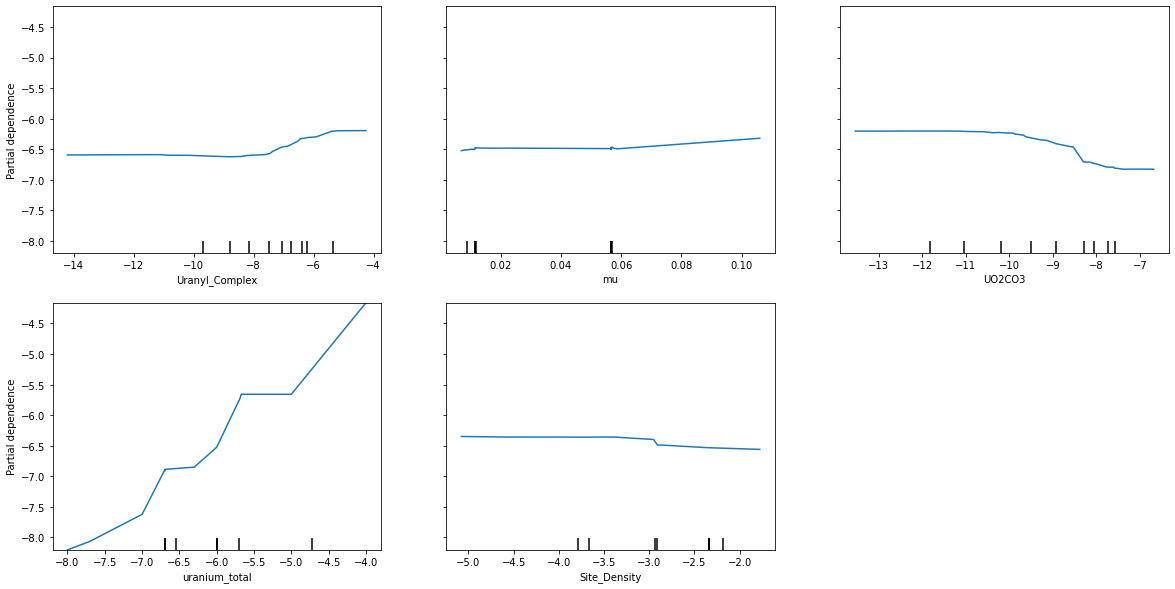

In [17]:
# Output random forest partial dependency plots

fig,ax = plt.subplots(figsize=(20,10))

tree_disp=PartialDependenceDisplay.from_estimator(onetrial[6],onetrial[4],["Uranyl_Complex","mu","UO2CO3","uranium_total","Site_Density"],ax=ax)

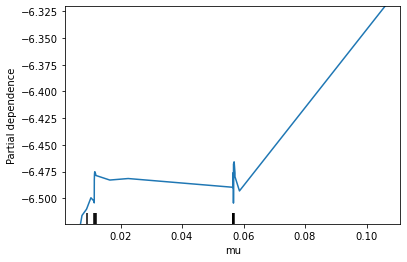

In [18]:
# Larger image of ionic strength partial dependency plot

tree_disp_mu=PartialDependenceDisplay.from_estimator(onetrial[6],onetrial[4],["mu"])

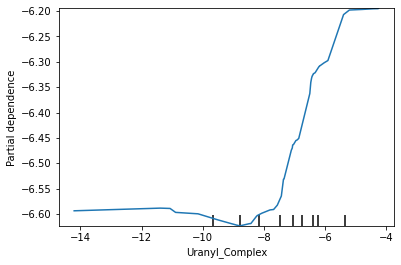

In [19]:
# Larger image of specific UO2+2 uranyl complex partial dependency plot

tree_disp_uranylcomplex=PartialDependenceDisplay.from_estimator(onetrial[6],onetrial[4],["Uranyl_Complex"])

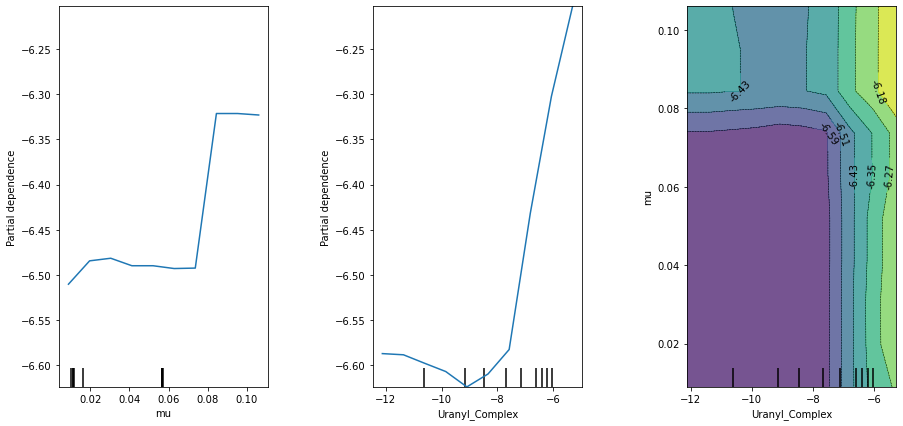

In [20]:
# Partial Dependence Plots for Ionic Strength and Uranyl Complexes

est = onetrial[6]
X_train = onetrial[7]
features = ["mu", "Uranyl_Complex", ("Uranyl_Complex", "mu")]
_, ax = plt.subplots(ncols=3, figsize=(15, 7))
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="average",
    n_jobs=2,
    grid_resolution=10,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.5, hspace=0.3)

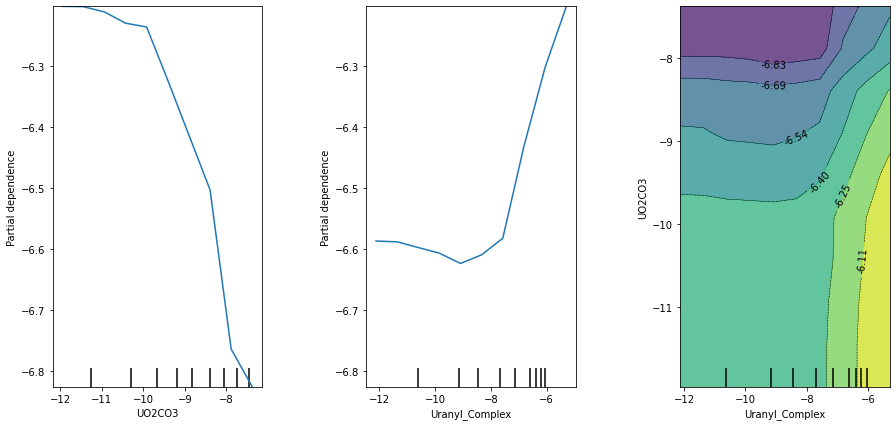

In [21]:
# Partial Dependence Plots for Bicarbonate and Uranyl Complexes

est = onetrial[6]
X_train = onetrial[7]
features = ["UO2CO3", "Uranyl_Complex", ("Uranyl_Complex", "UO2CO3")]
_, ax = plt.subplots(ncols=3, figsize=(15, 7))
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="average",
    n_jobs=2,
    grid_resolution=10,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.5, hspace=0.3)

### Total Model Error Quantification Based on Experimental Uncertainty Propagation

In [22]:
# Monte Carlo LSURF iterations for error quantification propagated from experimental uncertainties in initial data

def MC_LSURF(iterations):
    
    rows, cols = iterations, len(onetrial[2])
    repeated_error = []
    repeated_prediction = [] ##create a list of arrays for prediction
    repeated_x = []
    for _ in range(iterations):

        MLreadydata, Aq_U_array = randomized_transformation(df, df_temp)
        
        run=LSURF(15,MLreadydata,Aq_U_array)
        repeated_error.append(run[0])
        repeated_prediction.append(run[2])
        repeated_x.append(run[4].Uranyl_Complex)
    return repeated_error, repeated_prediction, repeated_x

In [23]:
# Monte Carlo LSURF iterations for error quantification propagated from experimental uncertainties in initial data

def MC_LSURF_R(iterations):
    
    rows, cols = iterations, len(onetrial[2])
    repeated_error = []
    weight = []
    actual = []
    repeated_prediction = [] ##create a list of arrays for prediction
    repeated_x = []
    for _ in range(iterations):

        MLreadydata, Aq_U_array = randomized_transformation(df, df_temp)
        
        run=LSURF(15,MLreadydata,Aq_U_array)
        weight.append(run[8])
        repeated_error.append(run[0])
        repeated_prediction.append(run[2])
        actual.append(run[3])
        repeated_x.append(run[4]["Uranyl_Complex"])
    return repeated_error, repeated_prediction, repeated_x, weight, actual

In [24]:
# Iterate 'number' times on Monte Carlo LSURF

number = 3 ## specify number of iterations
predictions = MC_LSURF_R(number)

CompletedProcess(args=['C:\\Users\\chang58\\Desktop\\LSURF_Package1\\phreeqc.exe', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.txt', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.out', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\LLNL_NEA.txt'], returncode=0)
None
None
Fitting 10 folds for each of 15 candidates, totalling 150 fits
CompletedProcess(args=['C:\\Users\\chang58\\Desktop\\LSURF_Package1\\phreeqc.exe', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.txt', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.out', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\LLNL_NEA.txt'], returncode=0)
None
None
Fitting 10 folds for each of 15 candidates, totalling 150 fits
CompletedProcess(args=['C:\\Users\\chang58\\Desktop\\LSURF_Package1\\phreeqc.exe', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.txt', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.out', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\LLNL_NEA.txt'], r

invalid value encountered in log10


Text(0, 0.5, 'Frequency')

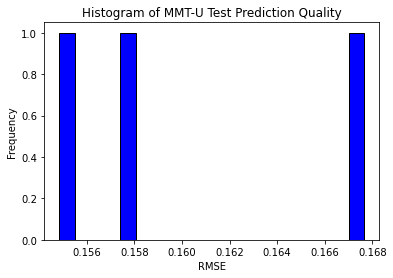

In [25]:
# Plot the error distribution of the test data

plt.hist(predictions[0], color = 'blue', edgecolor = 'black',
         bins = 20)
plt.title('Histogram of MMT-U Test Prediction Quality')
plt.xlabel('RMSE')
plt.ylabel('Frequency')

In [26]:
# Reporting average predicted value and associated standard deviations for each value

def predictionwitherror():
    prediction_std = []
    for z in range(0,len(predictions[1][0])):
        for n in range(0,len(predictions[1])):
            prediction_std.append((predictions[1][n][z])) 

    standard_deviations = []

    for n in range(0,len(predictions[1][0])*len(predictions[1]),len(predictions[1])):
        standard_deviations.append(np.std(prediction_std[n:n+len(predictions[1])]))
    
    return onetrial[2],np.array(standard_deviations)

### LSURF Model Analysis

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.


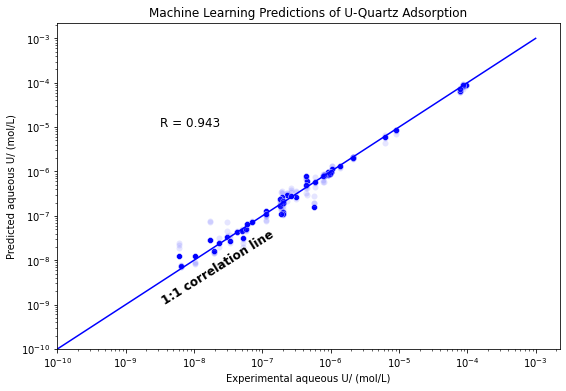

In [27]:
# Plotting the LSURF model test values vs experimental test data

f = plt.figure(figsize=[9,6])

line = [math.pow(10,-10),math.pow(10,-3)]

y_power=np.zeros(len(onetrial[2]))
x_power=np.zeros(len(onetrial[3]))
ypredictions=[]
xpredictions=[]

for n in range(0,number):
    for z in range(0,len(predictions[1][0])):
        ypredictions.append(math.pow(10,predictions[1][n][z]))
        #xpredictions.append(math.pow(10,onetrial[3][z]))
        xpredictions.append(math.pow(10,predictions[4][n][z]))
        
for n in range(0,len(onetrial[3])):
        x_power[n]=math.pow(10,onetrial[3][n])
        y_power[n]=math.pow(10,onetrial[2][n])

feat_plot=sns.scatterplot(x_power, y_power,color="b")  
sns.scatterplot(xpredictions,ypredictions,color="b",alpha=0.1)

#for n in range(0,number):
#    sns.scatterplot(x=onetrial[3], y=predictions[1][n],color="b", alpha=0.1)

sns.lineplot(x=line,y=line,color="b")
plt.ylabel('Predicted aqueous U/ (mol/L)')
plt.xlabel('Experimental aqueous U/ (mol/L)')
plt.title("Machine Learning Predictions of U-Quartz Adsorption")
feat_plot.set_xscale('log')
feat_plot.set_yscale('log')
plt.axis([math.pow(10,-10),math.pow(-10,-3),math.pow(10,-10),math.pow(-10,-3)])
feat_plot.text(math.pow(10,-8.5),math.pow(10,-5),'R = %0.3f' % R,fontsize=12)
feat_plot.text(math.pow(10,-8.5),math.pow(10,-9),'1:1 correlation line',fontsize=12,rotation=32,fontweight='bold')
plt.show()

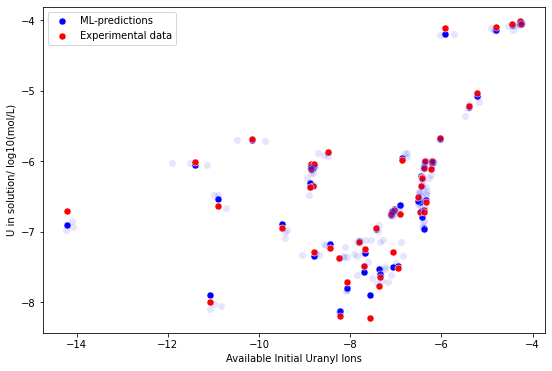

In [28]:
# Plotting the LSURF model predicted U adsorption vs initial U loading
# alongside experimental predicted U adsorption vs initial U loading.
# Shaded dots indicate MC-generated uncertainty values.

f = plt.figure(figsize=[9,6])

plt.subplot(1,1,1)
sns.scatterplot(x=onetrial[4].Uranyl_Complex,y=((onetrial[2])),color="b",label="ML-predictions",s=50)
sns.scatterplot(x=onetrial[4].Uranyl_Complex,y=((onetrial[3])),color="r",label="Experimental data",s=50)

for n in range(0,number):
    sns.scatterplot(x=predictions[2][n], y=(predictions[1][n]),color="b", alpha=0.1,s=50)

    
plt.legend()

#plt.axis([-13,-10,-10,-3])
plt.xlabel('Available Initial Uranyl Ions')
plt.ylabel('U in solution/ log10(mol/L)')
plt.legend()
#plt.text(-11,-2,'Machine Learning Predictions of U-Quartz Adsorption vs pH',fontsize=15) ## TITLE



plt.show()

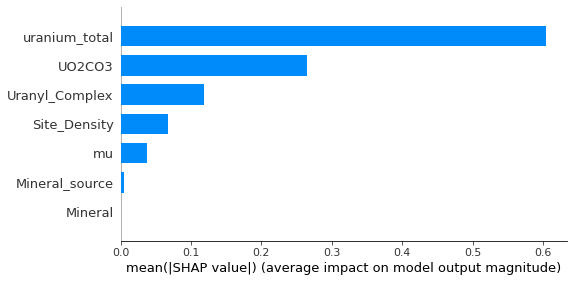

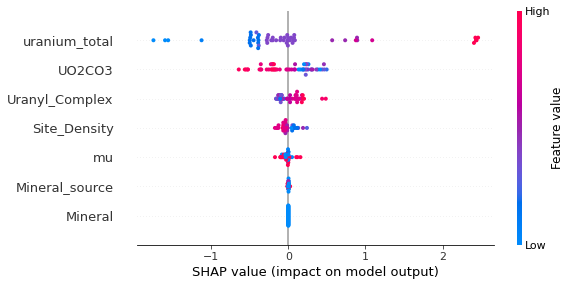

In [29]:
# Shapley importance values based on LSURF modeling

explainer = shap.TreeExplainer(onetrial[6])
shap_values = explainer.shap_values(onetrial[4])

shap.summary_plot(shap_values,onetrial[4],plot_type="bar")
shap.summary_plot(shap_values,onetrial[4])


The expected value is  [0.33901863] uM


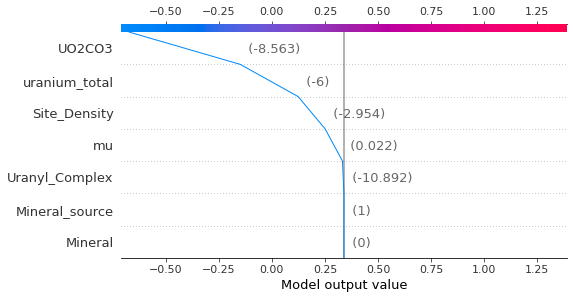

In [30]:
# Shapley based decision-making process for LSURF model

expected_value = np.power(10,explainer.expected_value)*np.power(10,6)

print("The expected value is ", expected_value, "uM")
shap_values = explainer.shap_values(onetrial[4])[1]
shap.decision_plot(expected_value, shap_values, onetrial[4])

### LSURF Model Saving and Loading

In [31]:
# Save trained LSURF model
joblib.dump(onetrial[6], "./trained_lsurf_model.joblib")


########################################################################

# to load in trained lsurf model
loaded_lsurf = joblib.load("./trained_lsurf_model.joblib")

# to use trained lsurf model
# loaded_lsurf.predict(Input_Dataframe_with_Features)

In [32]:
iterations = 3
repeated_error = []
repeated_average = []
repeated_prediction = [] ##create a list of arrays for prediction
repeated_x = []

for _ in range(iterations):

    MLreadydata, Aq_U_array = randomized_transformation(df, df_temp)
    run=loaded_lsurf.predict(MLreadydata)
    repeated_prediction.append(run)
    repeated_x.append(MLreadydata["Uranyl_Complex"])

repeated_prediction_array=np.concatenate(repeated_prediction[0:iterations])

for n in range(0,len(df)):
    repeated_error.append((np.log10(np.std(10**repeated_prediction_array[n:len(repeated_prediction_array):len(df)]))))
    repeated_average.append((np.mean(repeated_prediction_array[n:len(repeated_prediction_array):len(df)])))

CompletedProcess(args=['C:\\Users\\chang58\\Desktop\\LSURF_Package1\\phreeqc.exe', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.txt', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.out', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\LLNL_NEA.txt'], returncode=0)
None
None


invalid value encountered in log10


CompletedProcess(args=['C:\\Users\\chang58\\Desktop\\LSURF_Package1\\phreeqc.exe', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.txt', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.out', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\LLNL_NEA.txt'], returncode=0)
None
None


invalid value encountered in log10


CompletedProcess(args=['C:\\Users\\chang58\\Desktop\\LSURF_Package1\\phreeqc.exe', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.txt', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\python_trial.out', 'C:\\Users\\chang58\\Desktop\\LSURF_Package1\\LLNL_NEA.txt'], returncode=0)
None
None


### Final Plot of LSURF Model vs. Experimental Data (Training and Predictions)

In [33]:
# def MC_LSURF(iterations):
    
#     #rows, cols = iterations, len(df)
#     repeated_error = []
#     repeated_average = []
#     #weight = []
#     #actual = []
#     repeated_prediction = [] ##create a list of arrays for prediction
#     repeated_x = []
#     for _ in range(iterations):

#         MLreadydata, Aq_U_array = randomized_transformation(df, df_temp)
#         run=loaded_lsurf.predict(MLreadydata)
#         repeated_prediction.append(run)
#         repeated_x.append(MLreadydata["Uranyl_Complex"])
    
#     repeated_error.append(np.std(np.array(repeated_prediction[n:len(df)*iterations:len(df)])))
#     repeated_average.append(np.mean(np.array(repeated_prediction[n:len(df)*iterations:len(df)])))
    
    
#     return repeated_average, repeated_error, repeated_prediction, repeated_x #, weight, actual

In [34]:
# repeated_average, repeated_error, repeated_prediction, repeated_x = MC_LSURF(3)

In [35]:
#pestresults=pd.read_csv("Plotting.csv")

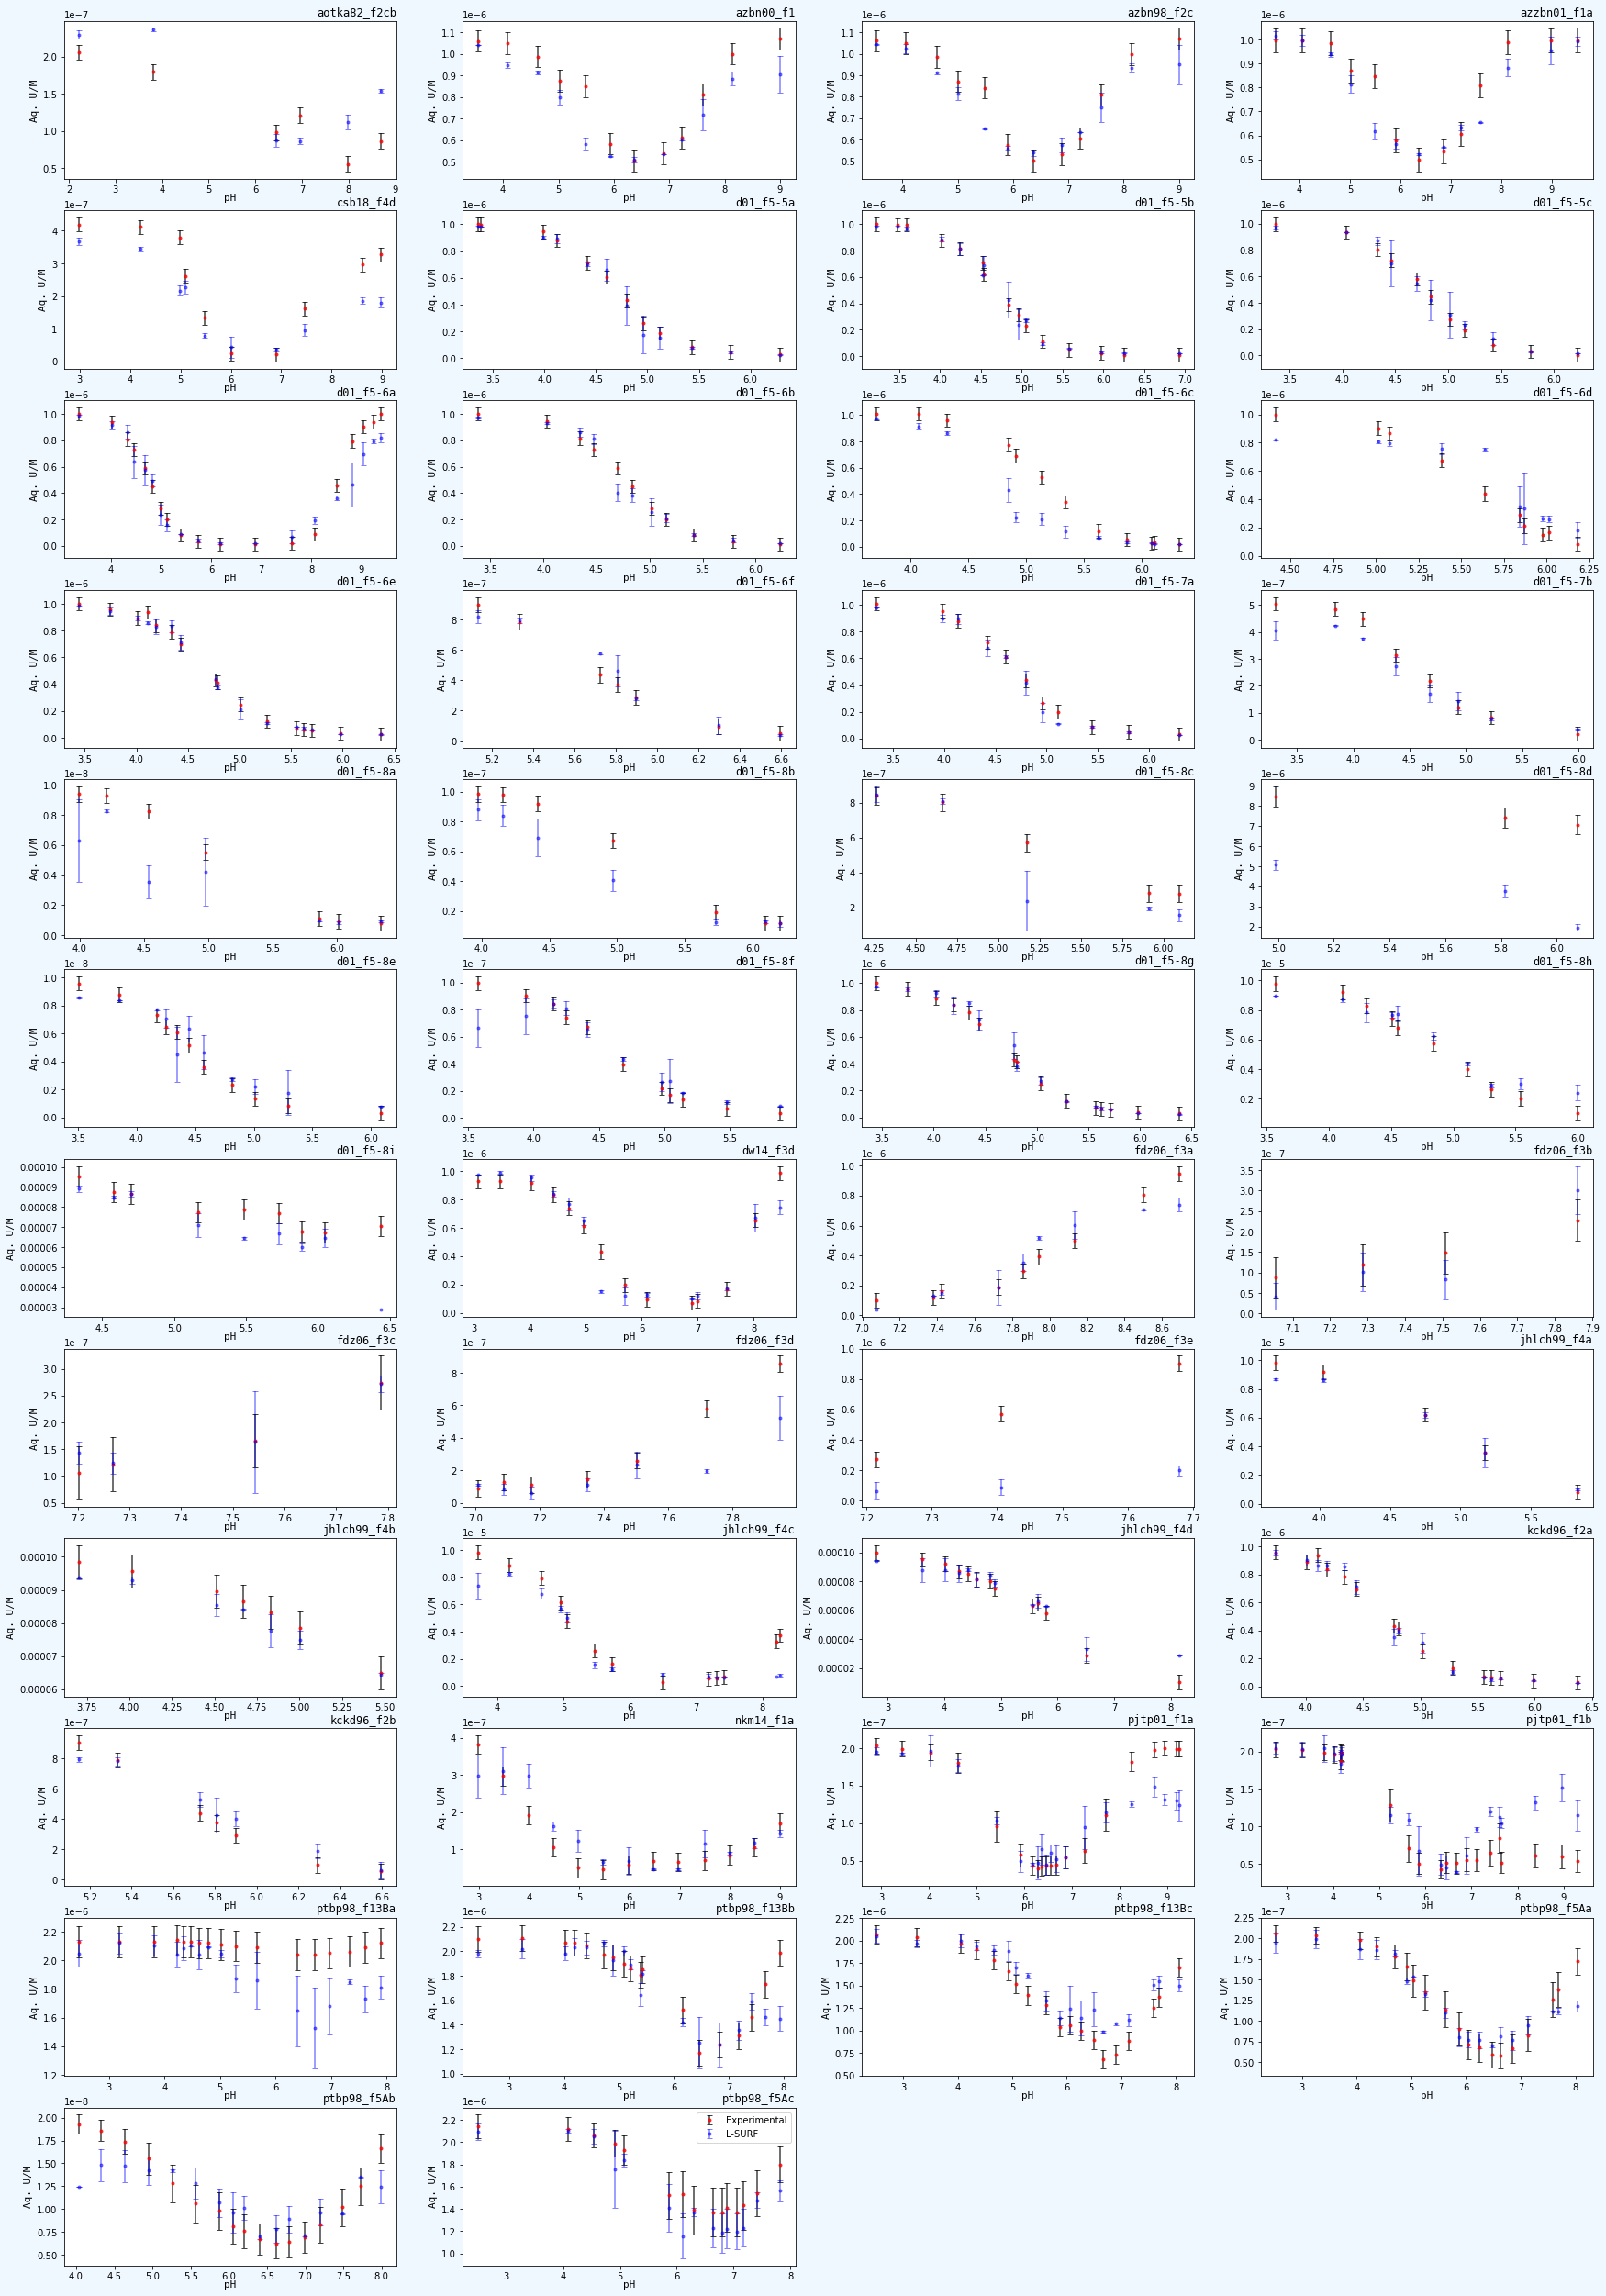

<Figure size 432x288 with 0 Axes>

In [36]:
df_plotting=df

predicted_aqueous_values=np.zeros(len(df_plotting["Aq_val"]))
prediction_for_plotting=loaded_lsurf.predict(MLreadydata_single)
for n in range(0,len(df_plotting["Aq_val"])):
    predicted_aqueous_values[n]=10**prediction_for_plotting[n]
    predicted_aqueous_values[n]=np.float64(f"{predicted_aqueous_values[n]:.2e}")
    
df_plotting["predicted_aq"]=repeated_average   
df_plotting["error_sd"]=repeated_error         

##########################################################################

# Note: here are two options for background color.

#plt.figure(figsize=((20,45)), facecolor='aliceblue', edgecolor='blue')
plt.figure(figsize=((26,45)), facecolor='aliceblue')
#plt.figure(figsize=((20,45)), facecolor='lightgray', edgecolor='blue')
############fig.set_tight_layout(True)


##########################################################################

plot_number2=1
plot_number=1
for Reference,selection in df_plotting.groupby("Set"):    
    plt.subplot(12,4,plot_number)
    #plt.scatter(selection['pH'],selection['Aq_val'],color="red")
    
    plt.errorbar(selection['pH'], selection['Aq_val'], yerr=selection['Aq_SD'], fmt='r.', 
                 capsize = 3, ecolor="black", elinewidth=1.5, alpha=0.75,label='Experimental')

    plt.errorbar(selection['pH'],10**selection['predicted_aq'], yerr=10**selection['error_sd'], fmt='b.',
                 capsize = 3, ecolor="blue", elinewidth=1.5, alpha=0.5, label = 'L-SURF')
    
    plt.title(Reference, loc='right', fontfamily='monospace', fontsize=12)
    plt.xlabel("pH", labelpad=-1,fontfamily='monospace', fontsize=11)
    plt.ylabel("Aq. U/M",fontfamily='monospace', fontsize=11)
    plot_number=plot_number+1
    
plt.subplots_adjust(left=0.01)   

plt.legend()
plt.show() 

# Temporarily have the following figure with a "_1" appended to name.
plt.savefig('sorption_edge_1.png',dpi=100)